<a href="https://colab.research.google.com/github/ayoolafelix/DSN-BootCamp-Qualificaton/blob/master/DSN_Bootcamp_Qualification_stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import catboost as cat_
import seaborn as sns
import lightgbm as lgb
import hyperopt

In [17]:
test = pd.read_csv('/content/gdrive/My Drive/DSN BootCamp Qualification/Test.csv')
train = pd.read_csv('/content/gdrive/My Drive/DSN BootCamp Qualification/Train.csv')
sample = pd.read_csv('/content/gdrive/My Drive/DSN BootCamp Qualification/SampleSubmission.csv')

In [18]:
train.set_index('Applicant_ID', inplace = True)
test.set_index('Applicant_ID', inplace = True)

In [19]:
train.fillna(-999, inplace = True)
test.fillna(-999, inplace = True)

In [27]:
class func() :   
    def __init__(self, train, label, test, model, model_type, random_state):
        self.train, self.label, self.test = train, label, test
        self.model, self.model_type = model, model_type
        self.random_state = random_state
        
        assert self.model_type in ('catboost', 'xgboost', 'lgbm'), 'Incorrect model_type'
    def __call__(self, plot = True):
        return self.fit(plot)

    def fit(self, plot):
        def catboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=500,
                           verbose=50,use_best_model=True)
            x_test_predict = self.model.predict_proba(X_test)[:,1]
            x_train_predict = self.model.predict_proba(X_train)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test)[:,1]
            return x_test_predict, x_train_predict

        def xgboost_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            x_train_predict = self.model.predict_proba(X_train, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, ntree_limit = self.model.get_booster().best_ntree_limit)[:,1]
            return x_test_predict, x_train_predict

        def lgbm_fit(X_train, X_test, y_train, y_test):
            self.model.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric="auc",
                           eval_set=[(X_test, y_test)], verbose = True)
            x_test_predict = self.model.predict_proba(X_test, num_iteration = self.model.best_iteration_)[:,1]
            x_train_predict = self.model.predict_proba(X_train, num_iteration = self.model.best_iteration_)[:,1]
            self.val_p[test_index] = x_test_predict
            self.test_p += self.model.predict_proba(self.test, num_iteration = self.model.best_iteration_)[:,1]
            return x_test_predict, x_train_predict


        self.val_p = np.zeros(self.train.shape[0])
        mean_val = []
        mean_train = []
        self.test_p = np.zeros(self.test.shape[0])
        splits = 15
        kf = StratifiedKFold(n_splits = splits)
        for fold_count, (train_index, test_index) in enumerate(kf.split(self.train, self.label)):
            X_train,X_test = self.train.iloc[train_index],self.train.iloc[test_index]
            y_train,y_test = self.label.iloc[train_index],self.label.iloc[test_index]

            print(f"================================Fold{fold_count+1}====================================")
            if self.model_type == 'catboost': x_test_predict, x_train_predict = catboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'xgboost': x_test_predict, x_train_predict = xgboost_fit(X_train, X_test, y_train, y_test)
            elif self.model_type == 'lgbm': x_test_predict, x_train_predict = lgbm_fit(X_train, X_test, y_train, y_test)

            print('\nValidation scores', roc_auc_score(y_test, x_test_predict), log_loss(y_test, x_test_predict))
            print('Training scores', roc_auc_score(y_train, x_train_predict), log_loss(y_train, x_train_predict))
            mean_val.append(roc_auc_score(y_test, x_test_predict))
            mean_train.append(roc_auc_score(y_train, x_train_predict))

        if plot:
            feat_imp = pd.DataFrame(sorted(zip(self.model.feature_importances_,self.train.columns)), columns=['Value','Feature'])
            plt.figure(figsize=(30,25))
            sns.barplot(x="Value", y="Feature", data=feat_imp.sort_values(by="Value", ascending=False))
            plt.ylabel('Feature Importance Score')
            plt.show()
        print(np.mean(mean_val), np.mean(mean_train), np.std(mean_val))
        return self.val_p, self.test_p/splits, self.model

In [21]:
dict_ = {'charge': 1,
         'lending': 0}

target_map = {
    'yes': 1,
    'no': 0}

train.default_status.replace(target_map, inplace = True)

train['form_field47'].replace(dict_, inplace = True)
test['form_field47'].replace(dict_, inplace = True)

In [22]:
target = train['default_status']
train.drop('default_status', axis = 1, inplace = True)


================================Fold1====================================
0:	learn: 0.7992292	test: 0.7903863	best: 0.7903863 (0)	total: 43.8ms	remaining: 2m 55s
50:	learn: 0.8268044	test: 0.8121727	best: 0.8121727 (50)	total: 1.16s	remaining: 1m 29s
100:	learn: 0.8322805	test: 0.8167309	best: 0.8167309 (100)	total: 2.21s	remaining: 1m 25s
150:	learn: 0.8356676	test: 0.8188896	best: 0.8188896 (150)	total: 3.28s	remaining: 1m 23s
200:	learn: 0.8380371	test: 0.8206336	best: 0.8206336 (200)	total: 4.36s	remaining: 1m 22s
250:	learn: 0.8400290	test: 0.8219750	best: 0.8219750 (250)	total: 5.43s	remaining: 1m 21s
300:	learn: 0.8416289	test: 0.8229241	best: 0.8229241 (300)	total: 6.51s	remaining: 1m 20s
350:	learn: 0.8430326	test: 0.8237514	best: 0.8237514 (350)	total: 7.61s	remaining: 1m 19s
400:	learn: 0.8443477	test: 0.8244113	best: 0.8244147 (399)	total: 8.69s	remaining: 1m 17s
450:	learn: 0.8455668	test: 0.8250276	best: 0.8250327 (448)	total: 9.77s	remaining: 1m 16s
500:	learn: 0.8467079

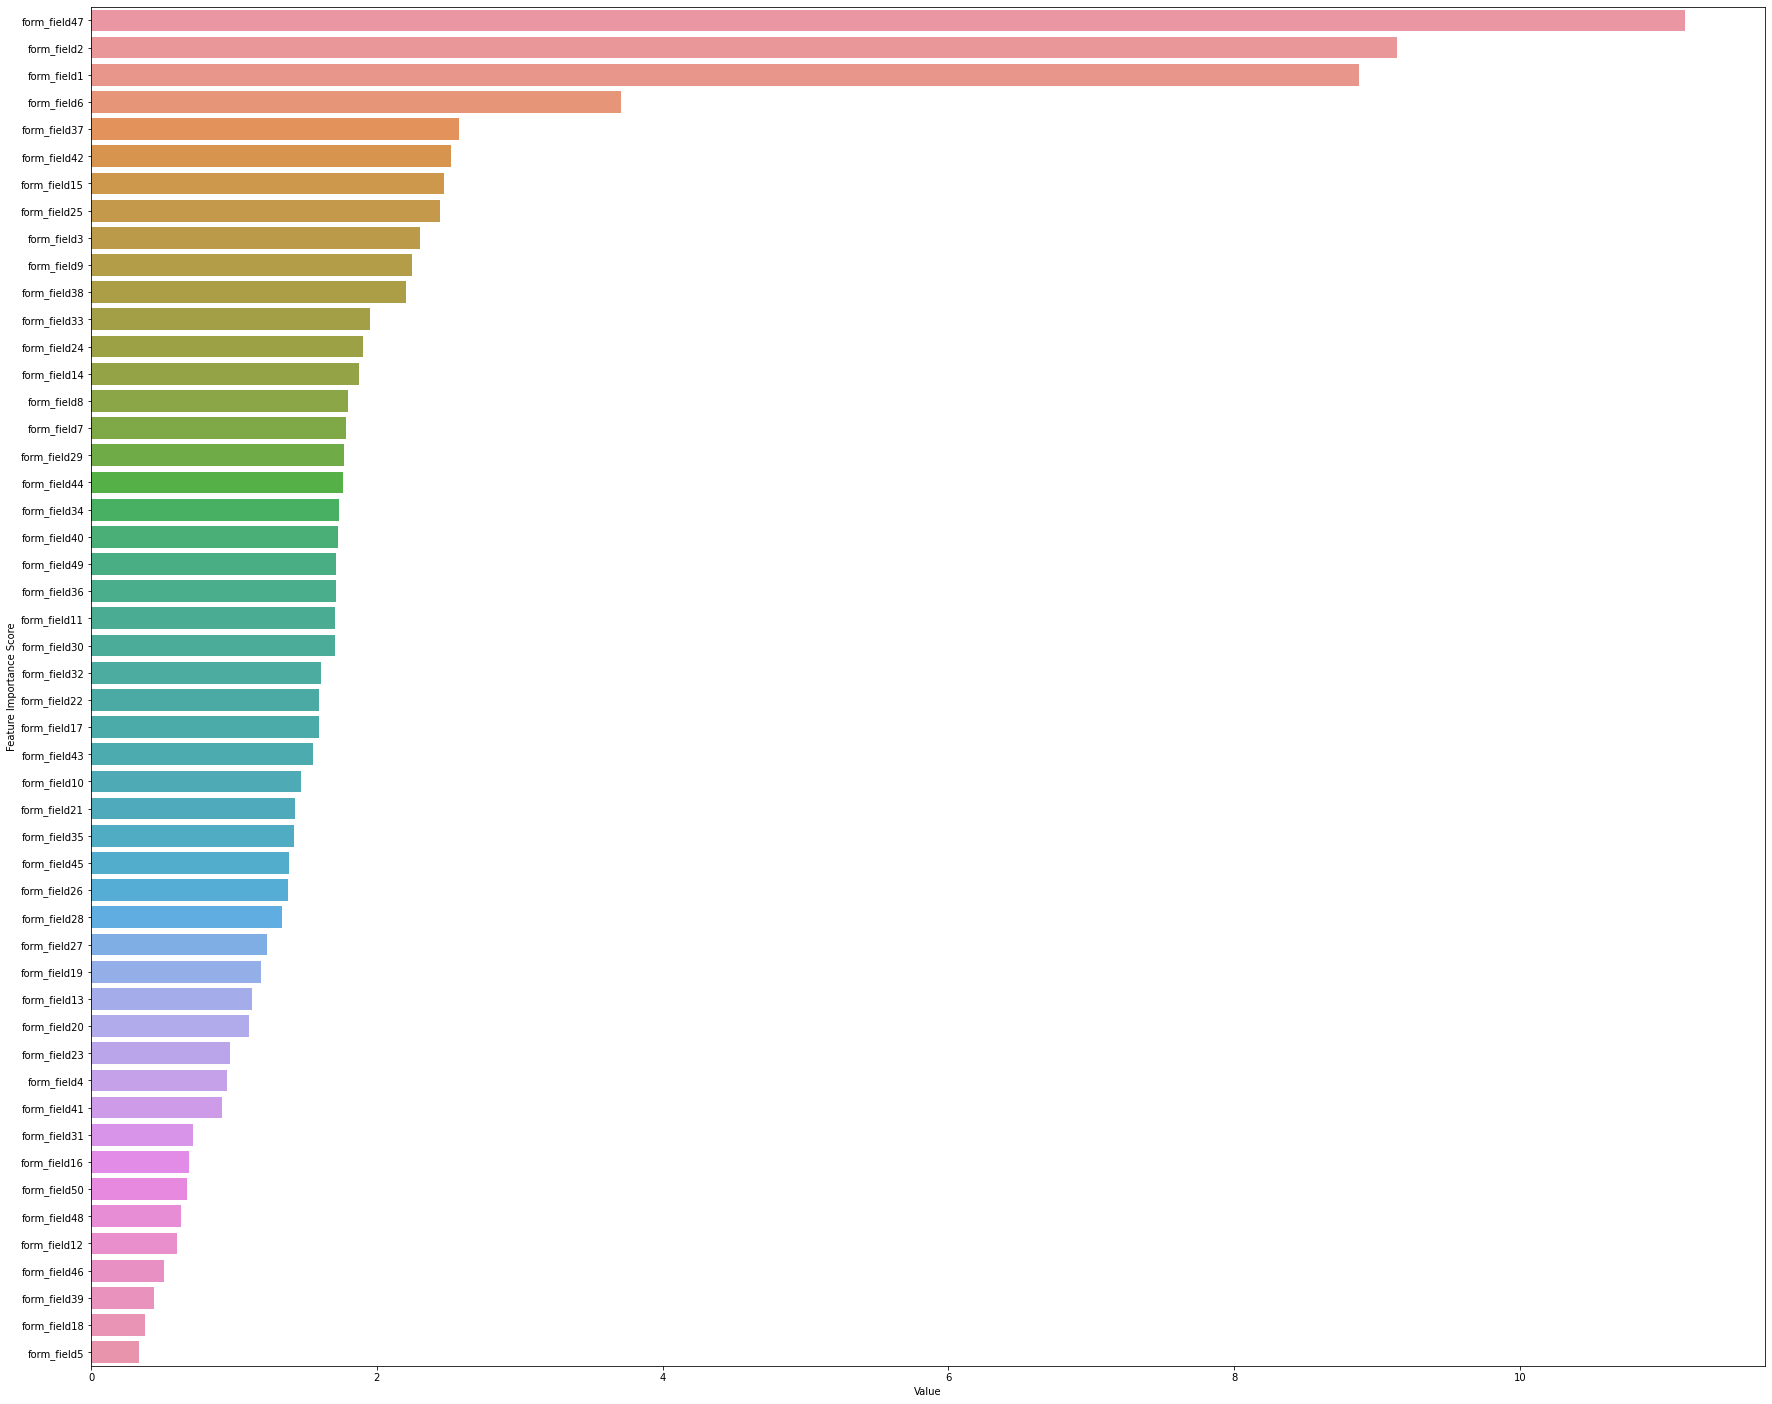

0.8414554861259418 0.8803623146032746 0.011566322826471406


In [28]:
catboost = cat_.CatBoostClassifier(n_estimators=4000, max_depth =9, eval_metric='AUC', reg_lambda = 370, task_type="GPU", devices='0:1', learning_rate = 0.0125, objective = 'CrossEntropy')

func_= func(train, target, test, catboost, 'catboost', 2020)
val_p1, test_p1, model1 = func_()

================================Fold1====================================
[0]	validation_0-auc:0.753268
Will train until validation_0-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.765065
[2]	validation_0-auc:0.773444
[3]	validation_0-auc:0.777981
[4]	validation_0-auc:0.780425
[5]	validation_0-auc:0.787543
[6]	validation_0-auc:0.789745
[7]	validation_0-auc:0.792347
[8]	validation_0-auc:0.794129
[9]	validation_0-auc:0.796888
[10]	validation_0-auc:0.799752
[11]	validation_0-auc:0.801966
[12]	validation_0-auc:0.804501
[13]	validation_0-auc:0.805951
[14]	validation_0-auc:0.806068
[15]	validation_0-auc:0.807729
[16]	validation_0-auc:0.810054
[17]	validation_0-auc:0.810462
[18]	validation_0-auc:0.811133
[19]	validation_0-auc:0.812945
[20]	validation_0-auc:0.813387
[21]	validation_0-auc:0.814383
[22]	validation_0-auc:0.815081
[23]	validation_0-auc:0.81528
[24]	validation_0-auc:0.816503
[25]	validation_0-auc:0.81712
[26]	validation_0-auc:0.817623
[27]	validation_0-auc:0.818135
[28]	v

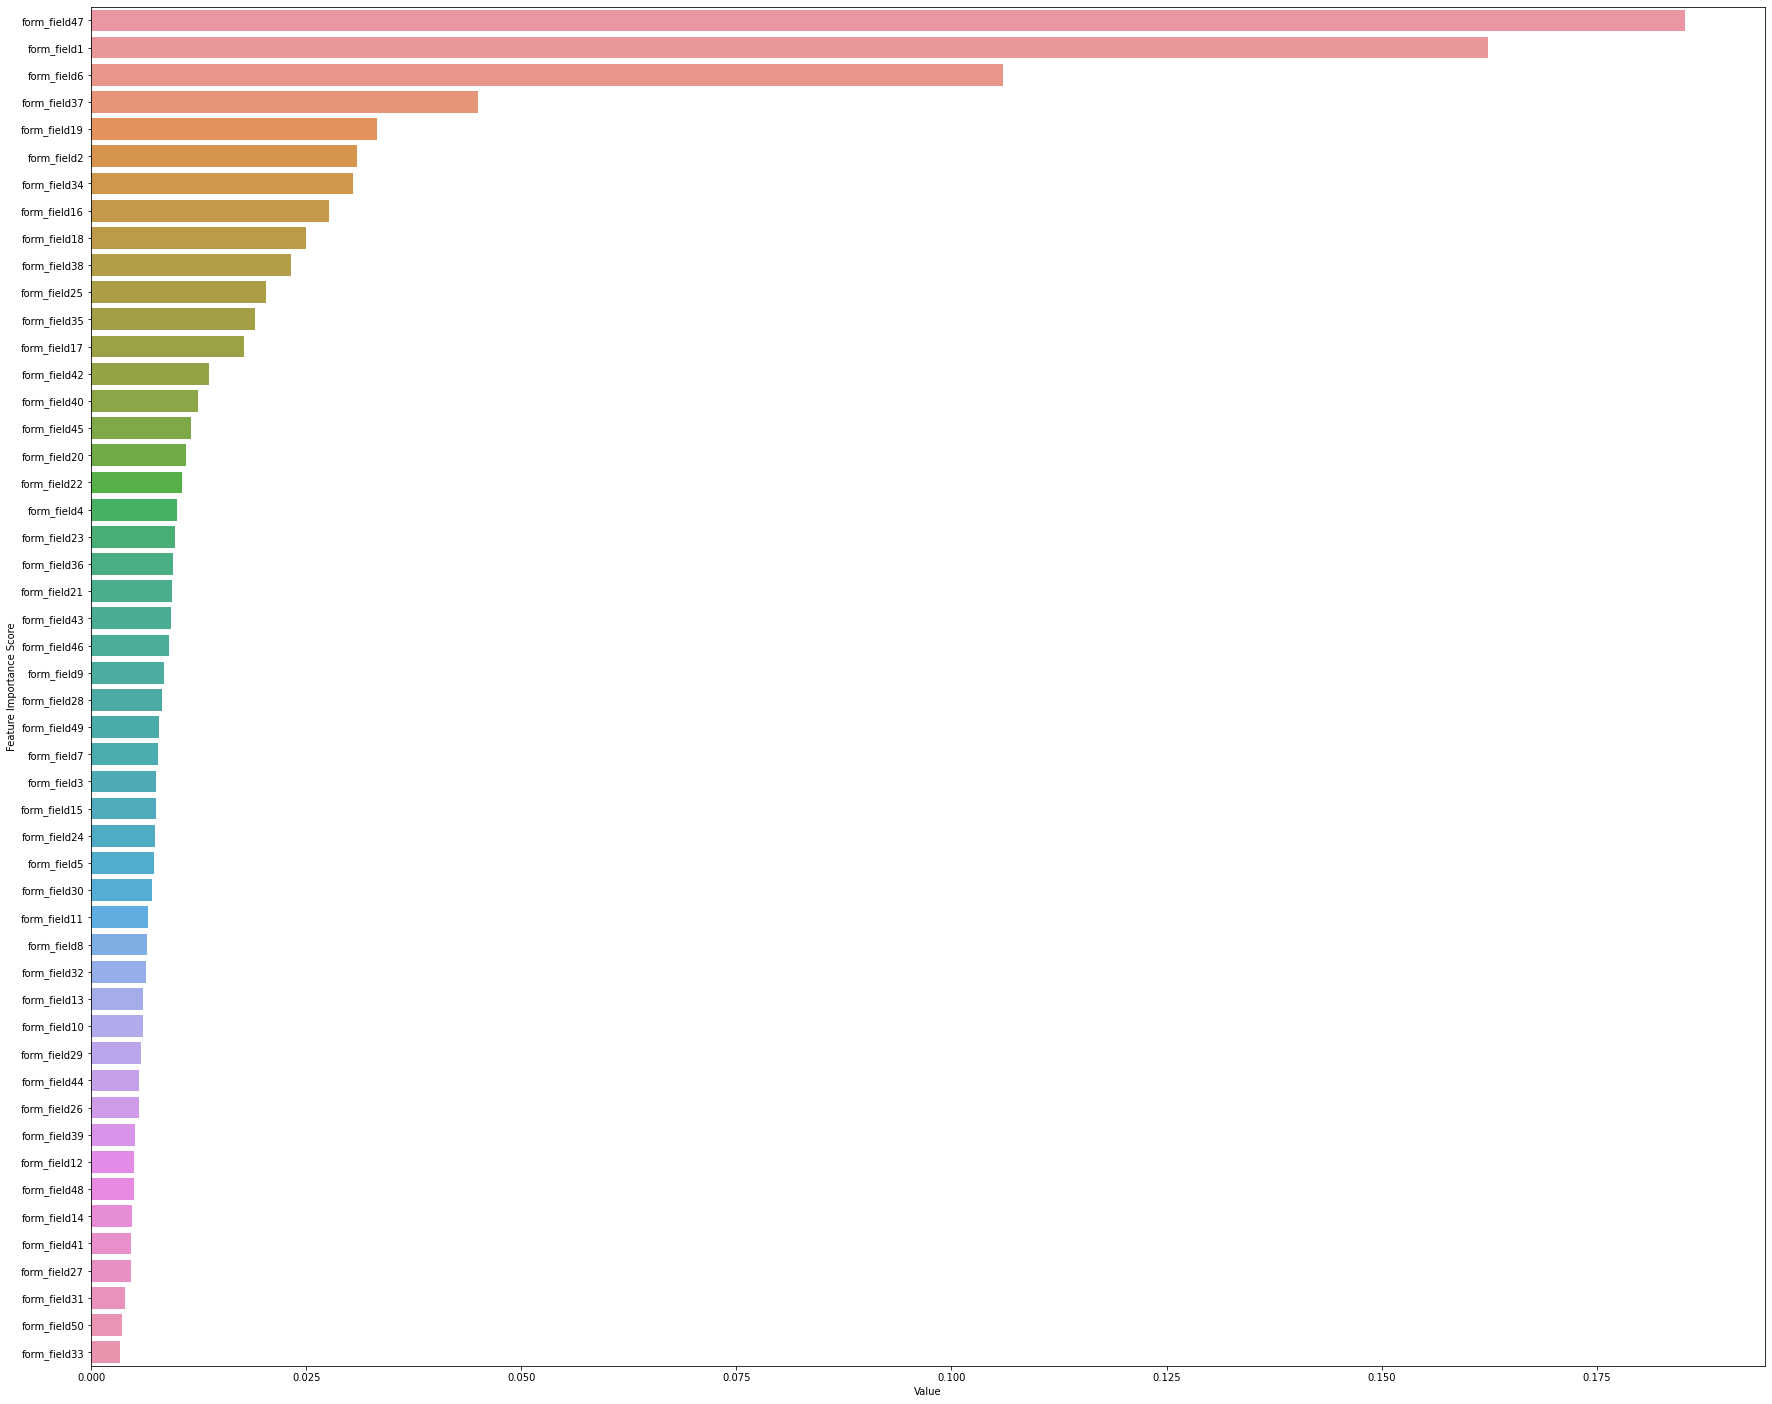

0.8398567865778543 0.8687838069421112 0.012285282195425531


In [29]:
xgboost = xgb.XGBClassifier(objective ='binary:logistic', 
                          eta = 0.99,
                          max_depth = 6, 
                          n_estimators = 5000,
                          reg_lambda = 500,
                          sub_sample = 0.8,
                          colsample_bytree = 0.8, tree_method='gpu_hist', gpu_id=0)

func_= func(train, target, test, xgboost, 'xgboost', 1000)
val_p2, test_p2, model2 = func_()

================================Fold1====================================
[1]	valid_0's auc: 0.789666
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.799744
[3]	valid_0's auc: 0.800145
[4]	valid_0's auc: 0.802365
[5]	valid_0's auc: 0.806573
[6]	valid_0's auc: 0.807693
[7]	valid_0's auc: 0.809638
[8]	valid_0's auc: 0.81122
[9]	valid_0's auc: 0.81233
[10]	valid_0's auc: 0.812903
[11]	valid_0's auc: 0.813822
[12]	valid_0's auc: 0.814894
[13]	valid_0's auc: 0.816612
[14]	valid_0's auc: 0.816802
[15]	valid_0's auc: 0.817328
[16]	valid_0's auc: 0.818116
[17]	valid_0's auc: 0.818459
[18]	valid_0's auc: 0.818688
[19]	valid_0's auc: 0.819348
[20]	valid_0's auc: 0.819698
[21]	valid_0's auc: 0.82005
[22]	valid_0's auc: 0.820519
[23]	valid_0's auc: 0.820758
[24]	valid_0's auc: 0.821036
[25]	valid_0's auc: 0.821436
[26]	valid_0's auc: 0.821589
[27]	valid_0's auc: 0.821872
[28]	valid_0's auc: 0.822178
[29]	valid_0's auc: 0.822309
[30]	valid_0's auc: 0.822729
[31]	v

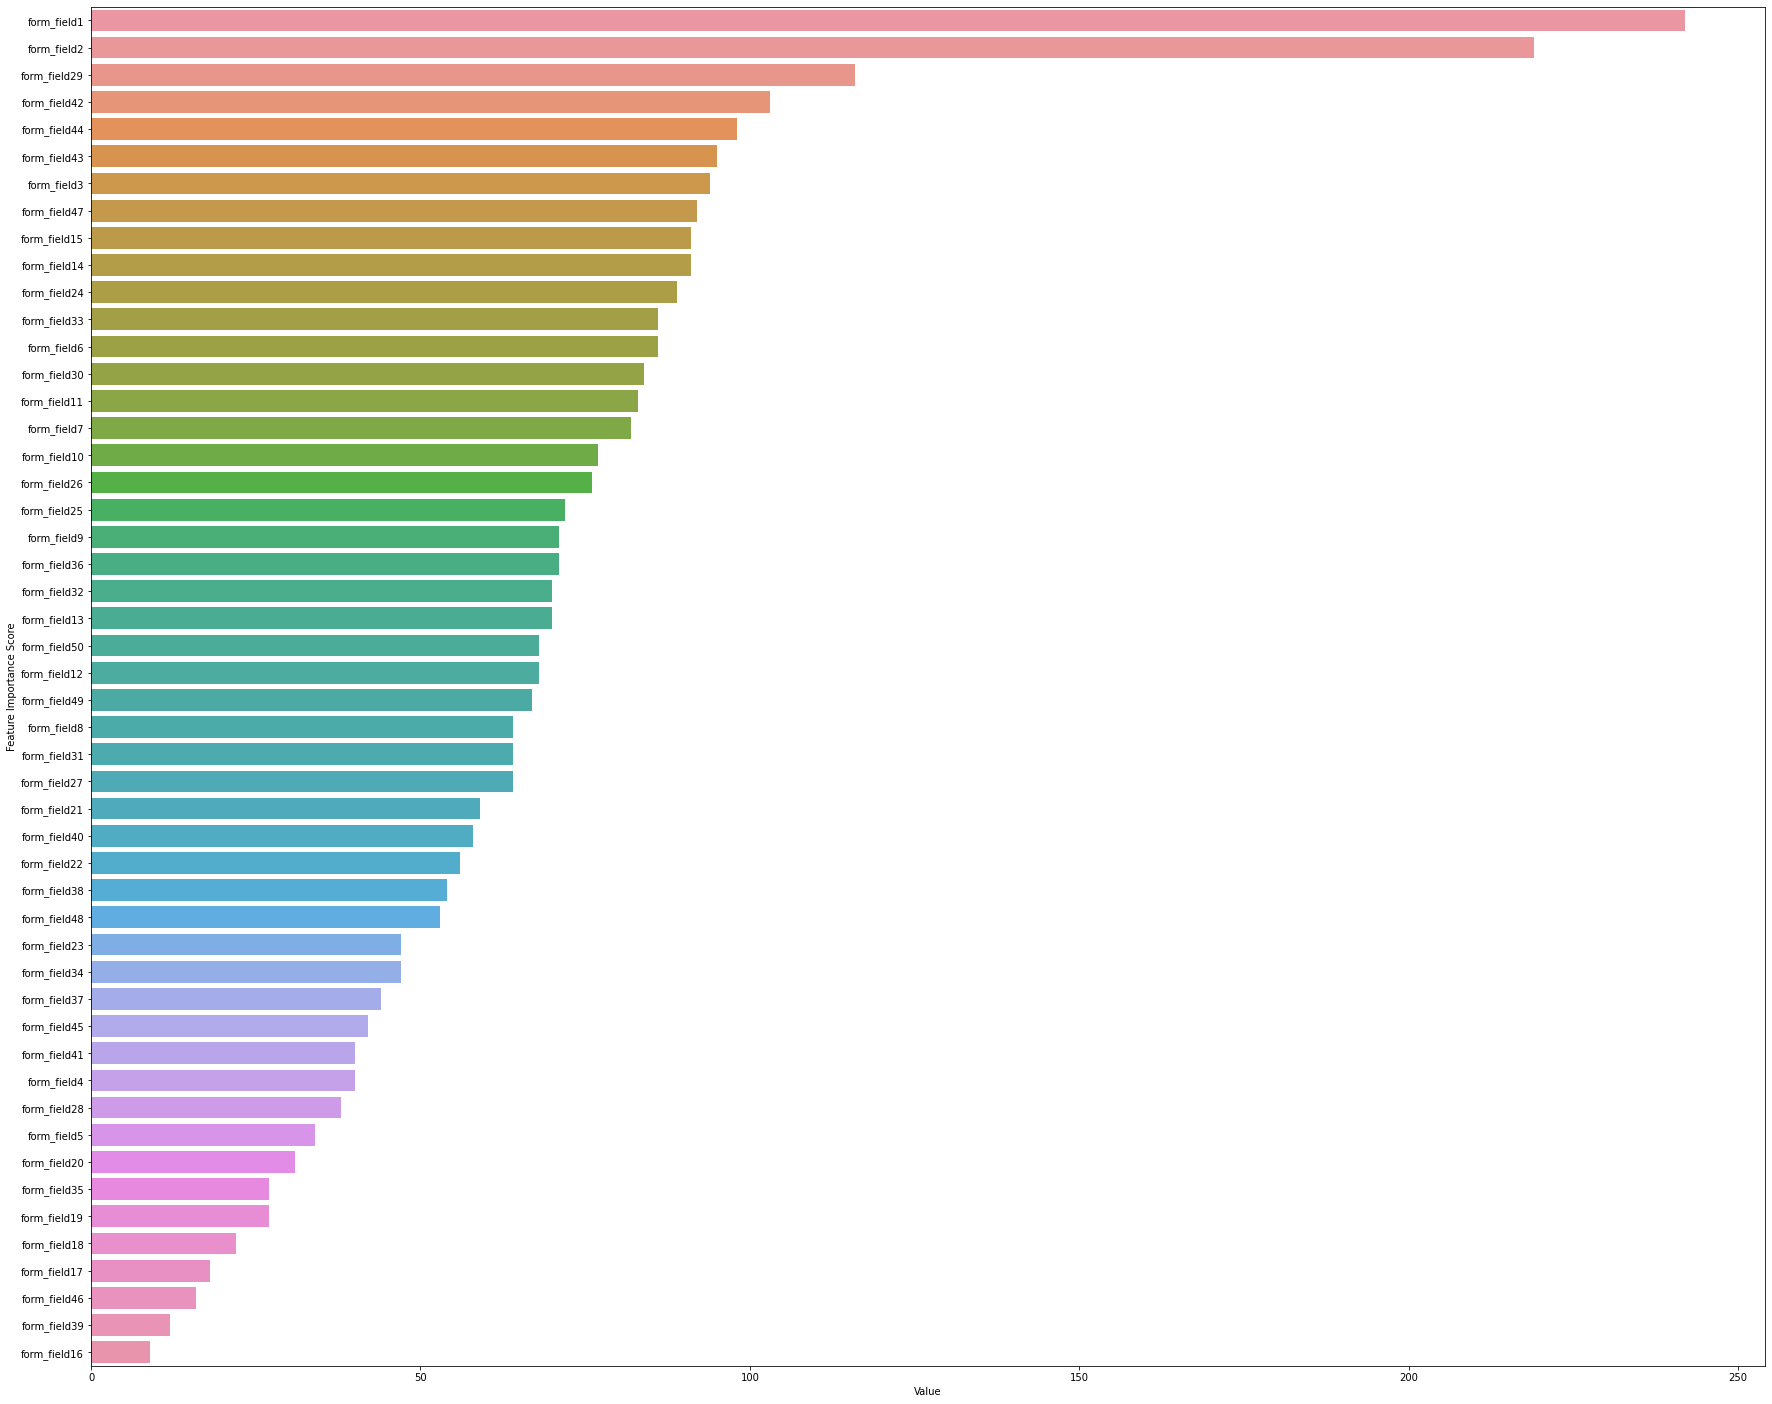

0.8388650215923225 0.8699962732390841 0.01154966195193993


In [30]:
lgb_model = lgb.LGBMClassifier(objective =  'binary', 
                            metric= 'auc',
                            boosting_type= 'gbdt',
                            lambda_l1= 0.0004912993970392775,
                            lambda_l2= 9.424350138808432,
                            num_leaves= 24,
                            feature_fraction= 1.0,
                            bagging_fraction= 0.9540416539312312,
                            bagging_freq= 7,
                            min_child_samples= 100, n_estimators = 300)

func_= func(train, target, test, lgb_model, 'lgbm', 1000)
val_p3, test_p3, model3 = func_()

In [31]:
from sklearn.linear_model import  LinearRegression, Ridge, Lasso
stack = np.column_stack((val_p1, val_p2, val_p3))
stack_p = np.column_stack((test_p1, test_p2, test_p3))
predict = LinearRegression().fit(stack, target).predict(stack_p)

In [33]:
sample['default_status'] = predict

sample.to_csv('solution_stack.csv',index=False)